In [1]:
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from LPIPS import LPIPS
from ImageProcessor import ImageProcessor

from NST import NST
import warnings
import time
warnings.filterwarnings("ignore")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
#Based on https://github.com/ceshine/fast-neural-style/
class JohnsonModel(NST):
    def __init__(self, content_path, style_paths, prebuild_encoder = None, prebuild_decoder = None):
        super().__init__(content_path, style_paths, prebuild_encoder, prebuild_decoder)
        self.norm_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        self.norm_std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)
        self.transformer = self.TransformerNet()
        
    def uploadModel(self, input):
        self.encoder = input
        self.loss_net = self.LossNetwork(self.encoder)

    def loadModel(self, path):
        eState = torch.load(path, map_location="cpu")
        self.transformer.load_state_dict(eState)
       
    class LossNetwork(nn.Module):
        def __init__(self, encoder):
            super().__init__()
            self.vgg_layers = encoder
            self.layer_name_mapping = {
                '3': "relu1",
                '8': "relu2",
                '17': "relu3",
                '26': "relu4",
                '35': "relu5",
            }
    
        def forward(self, x):
            output = {}
            for name, module in self.vgg_layers._modules.items():
                x = module(x)
                if name in self.layer_name_mapping:
                    output[self.layer_name_mapping[name]] = x
            return output
            
    class TransformerNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ConvLayer = JohnsonModel.ConvLayer
            self.ResidualBlock = JohnsonModel.ResidualBlock
            self.UpsampleConvLayer = JohnsonModel.UpsampleConvLayer
            # Initial convolution layers
            self.conv1 = self.ConvLayer(3, 32, kernel_size=9, stride=1)
            self.in1 = nn.InstanceNorm2d(32, affine=True)
            self.conv2 = self.ConvLayer(32, 64, kernel_size=3, stride=2)
            self.in2 = nn.InstanceNorm2d(64, affine=True)
            self.conv3 = self.ConvLayer(64, 128, kernel_size=3, stride=2)
            self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
            # Residual layers
            self.res1 = self.ResidualBlock(128)
            self.res2 = self.ResidualBlock(128)
            self.res3 = self.ResidualBlock(128)
            self.res4 = self.ResidualBlock(128)
            self.res5 = self.ResidualBlock(128)
            # Upsampling Layers
            self.deconv1 = self.UpsampleConvLayer(
                128, 64, kernel_size=3, stride=1, upsample=2)
            self.in4 = nn.InstanceNorm2d(64, affine=True)
            self.deconv2 = self.UpsampleConvLayer(
                64, 32, kernel_size=3, stride=1, upsample=2)
            self.in5 = nn.InstanceNorm2d(32, affine=True)
            self.deconv3 = self.ConvLayer(32, 3, kernel_size=9, stride=1)
            # Non-linearities
            self.relu = nn.ReLU()
    
        def forward(self, X):
            y = self.relu(self.in1(self.conv1(X)))
            y = self.relu(self.in2(self.conv2(y)))
            y = self.relu(self.in3(self.conv3(y)))
            y = self.res1(y)
            y = self.res2(y)
            y = self.res3(y)
            y = self.res4(y)
            y = self.res5(y)
            y = self.relu(self.in4(self.deconv1(y)))
            y = self.relu(self.in5(self.deconv2(y)))
            y = self.deconv3(y)
            return y


    class ConvLayer(nn.Module):
        def __init__(self, in_channels, out_channels, kernel_size, stride):
            super().__init__()
            reflection_padding = kernel_size // 2
            self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
            self.conv2d = torch.nn.Conv2d(
                in_channels, out_channels, kernel_size, stride)
    
        def forward(self, x):
            out = self.reflection_pad(x)
            out = self.conv2d(out)
            return out
    
    
    class ResidualBlock(nn.Module):
    
        def __init__(self, channels):
            super().__init__()
            self.ConvLayer = JohnsonModel.ConvLayer
            self.conv1 = self.ConvLayer(channels, channels, kernel_size=3, stride=1)
            self.in1 = nn.InstanceNorm2d(channels, affine=True)
            self.conv2 = self.ConvLayer(channels, channels, kernel_size=3, stride=1)
            self.in2 = nn.InstanceNorm2d(channels, affine=True)
            self.relu = nn.ReLU()
    
        def forward(self, x):
            residual = x
            out = self.relu(self.in1(self.conv1(x)))
            out = self.in2(self.conv2(out))
            out = out + residual
            return out
    
    
    class UpsampleConvLayer(nn.Module):

        def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
            super().__init__()
            self.upsample = upsample
            if upsample:
                self.upsample_layer = torch.nn.Upsample(
                    mode='nearest', scale_factor=upsample)
            reflection_padding = kernel_size // 2
            self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
            self.conv2d = torch.nn.Conv2d(
                in_channels, out_channels, kernel_size, stride)
    
        def forward(self, x):
            x_in = x
            if self.upsample:
                x_in = self.upsample_layer(x_in)
            out = self.reflection_pad(x_in)
            out = self.conv2d(out)
            return out
    
    @staticmethod
    def gram_matrix(y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram

    def normalisation(self, input):
        return (input - self.norm_mean) / self.norm_std

    @staticmethod
    def tv_loss(img):
        return torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
               torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
        
    def prepare_style(self):
        style = self.styles[0].tensorisedImage(1) 
        
        feats_s = self.loss_net(style)

        self._style_grams = {k: self.gram_matrix(v) for k, v in feats_s.items()}

    def train(self, train_loader, steps=300, lr=1e-3,content_weight=1.0, style_weight=1e5, regularisation=1e-6, log_interval=50):

        if self._style_grams is None:
            self.prepare_style()

        self.transformer.train()
        optim = torch.optim.Adam(self.transformer.parameters(), lr=lr)
        mse = nn.MSELoss()

        step = 0
        running_c = running_s = running_tv = 0.0

        while step < steps:
            for x, _ in train_loader:
                step += 1
                if step > steps:
                    break

                optim.zero_grad()

                y = self.transformer(x)

                y_n = self.normalisation(y)
                x_n = self.normalisation(x)
                
                feats_y = self.loss_net(y_n)
                feats_x = self.loss_net(x_n)

                content_loss = content_weight * mse(feats_y["relu2"], feats_x["relu2"].detach())

                style_loss = 0.0
                for k in self._style_grams.keys():
                    style_loss = style_loss + mse(self.gram_matrix(feats_y[k]), self._style_grams[k].expand_as(self.gram_matrix(feats_y[k])))
                style_loss = style_weight * style_loss

                tv = regularisation * self.tv_loss(y)

                total = content_loss + style_loss + tv
                total.backward()
                optim.step()

                running_c += float(content_loss)
                running_s += float(style_loss)
                running_tv += float(tv)

                if step % log_interval == 0:
                    print(f"[{step}/{steps}] content={running_c/log_interval:.2f} style={running_s/log_interval:.2f} tv={running_tv/log_interval:.6f}")
                    running_c = running_s = running_tv = 0.0

    def pipeline(self, train_loader, output_path):
        self.prepare_style()
        #Start counter (as new image need training)
        self.start = time.perf_counter()
        
        self.train(
        train_loader=train_loader,
        steps = 300)
        torch.save(self.transformer.state_dict(), output_path)
        

    def stylise(self):
        self.stylisingTime = time.perf_counter()
        content = self.content.tensorisedImage(1) 
        output = self.transformer(content)
        self.end = time.perf_counter() #end timer
        
        self.stylisedTensor = output.detach().clamp(0, 1)
        self.stylisedImage = self.stylisedTensor.squeeze(0).permute(1,2,0).numpy()

        timePassed = (self.end - self.stylisingTime) * 1000

        print(f"Style Time:{timePassed:.3f} ms")
        

In [3]:
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.eval()

for p in model.parameters():
    p.requires_grad_(False)

transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(
    root="content",             
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
image_path = "content/avril.jpg"
style_path = "style/sketch.png"

nstModel = JohnsonModel(image_path,[style_path])
nstModel.uploadModel(model)
nstModel.processor()
nstModel.pipeline(train_loader, "johnson-sketch.pth")
nstModel.stylise()
    

[50/300] content=8.05 style=26625.61 tv=0.000000
[100/300] content=1.87 style=25.62 tv=0.000000
[150/300] content=1.74 style=6.26 tv=0.000000
[200/300] content=1.70 style=3.86 tv=0.000000
[250/300] content=1.67 style=3.03 tv=0.000000
[300/300] content=1.65 style=2.57 tv=0.000000
Style Time:2051.238 ms


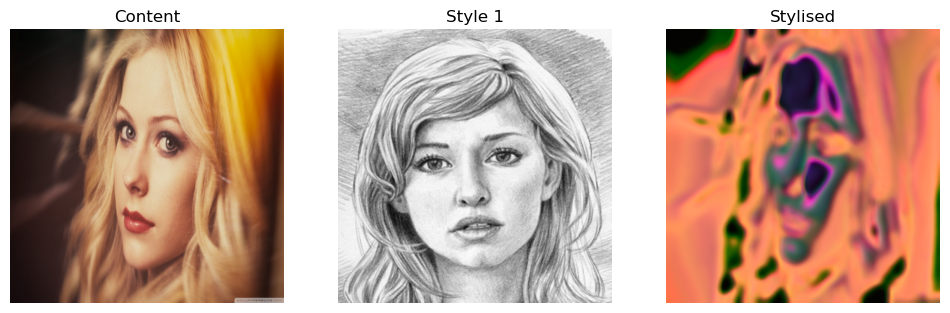

In [4]:
nstModel.displayImages()

In [5]:
nstModel.evaluate()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


(0.687, '1965689.178 ms')